In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam 
from pyro.infer import Predictive

In [9]:
def model2(game_info, obs=None):
    """
    Inputs: 
        obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.

    Output: A 1D tensor of the same length as the input tensor. Represents a sample from difference in performance between the two coaches.
    """
    
    hyper_sigma = 1/8 # consider if this variable is maintained constant during inference.
    # do we want it to be constant?
    
    coach1_mu_skill = 0
    coach1_sigma_skill = 1
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_mu_skill = 0
    coach2_sigma_skill = 1
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

# Training on fake data where coach 1 always wins.

In [10]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100

# train the model on fake data where coach 1 always wins.
game_info = {}
obs = torch.ones(num_games)
for step in range(num_steps):    
    loss = svi.step(game_info, obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 3182.7276747226715
Step 100 : loss = -36.27677023410797
Step 200 : loss = -7.2998305559158325
Step 300 : loss = -33.06042146682739
Step 400 : loss = 1.1933295726776123
Step 500 : loss = -33.445281982421875
Step 600 : loss = -27.079550981521606
Step 700 : loss = -39.49732327461243
Step 800 : loss = -32.10783886909485
Step 900 : loss = -39.89678430557251
Step 1000 : loss = -14.534337282180786
Step 1100 : loss = -29.83367419242859
Step 1200 : loss = -46.405290961265564
Step 1300 : loss = -33.211363673210144
Step 1400 : loss = -32.892329454422
Step 1500 : loss = -33.485814332962036
Step 1600 : loss = -35.76899003982544
Step 1700 : loss = -24.551862597465515
Step 1800 : loss = -25.336050033569336
Step 1900 : loss = -38.63118648529053
Step 2000 : loss = -37.74501621723175
Step 2100 : loss = -25.64239799976349
Step 2200 : loss = -27.7755606174469
Step 2300 : loss = -37.7570915222168
Step 2400 : loss = -22.125744938850403
Step 2500 : loss = -45.0294713973999
Step 2600 : loss = 

In [11]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

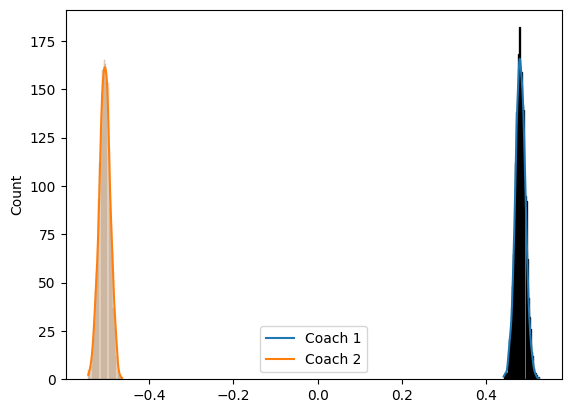

In [12]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Training on fake data where each match is a draw.

In [14]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100

obs = torch.zeros(num_games)
for step in range(num_steps):    
    loss = svi.step(game_info, obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = -4.072000741958618
Step 100 : loss = -20.093456983566284
Step 200 : loss = -33.608565866947174
Step 300 : loss = 6.592833757400513
Step 400 : loss = -34.43877422809601
Step 500 : loss = -32.96952873468399
Step 600 : loss = -27.85571140050888
Step 700 : loss = -33.794241189956665
Step 800 : loss = -28.713054716587067
Step 900 : loss = -32.18555694818497
Step 1000 : loss = -23.70494908094406
Step 1100 : loss = -34.53415143489838
Step 1200 : loss = -30.07903778553009
Step 1300 : loss = -32.189844250679016
Step 1400 : loss = -41.780013620853424
Step 1500 : loss = -45.057343661785126
Step 1600 : loss = -30.622905254364014
Step 1700 : loss = -43.8651008605957
Step 1800 : loss = -36.31884229183197
Step 1900 : loss = -31.427309930324554
Step 2000 : loss = -26.07636070251465
Step 2100 : loss = -34.852260410785675
Step 2200 : loss = -25.157894372940063
Step 2300 : loss = -29.974033534526825
Step 2400 : loss = -32.038651525974274
Step 2500 : loss = -26.96337527036667
Step 2600 : l

In [16]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

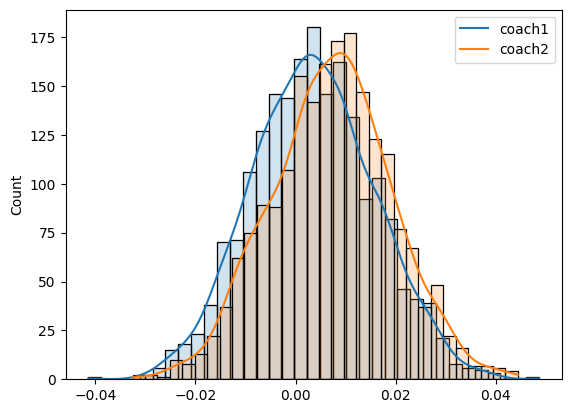

In [17]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where coach 2 always wins.

In [19]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100

obs = -torch.ones(num_games)
for step in range(num_steps):    
    loss = svi.step(game_info, obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 3296.9489864706993
Step 100 : loss = 9.077323853969574
Step 200 : loss = -28.585901141166687
Step 300 : loss = -18.9049950838089
Step 400 : loss = -33.796488761901855
Step 500 : loss = -24.17885196208954
Step 600 : loss = -22.768869280815125
Step 700 : loss = -38.369001507759094
Step 800 : loss = -26.235654830932617
Step 900 : loss = -34.84654223918915
Step 1000 : loss = -37.2596116065979
Step 1100 : loss = -44.87744319438934
Step 1200 : loss = -17.65284836292267
Step 1300 : loss = -31.997169733047485
Step 1400 : loss = -33.84656345844269
Step 1500 : loss = -26.451056599617004
Step 1600 : loss = -43.681110858917236
Step 1700 : loss = -33.326443672180176
Step 1800 : loss = -21.33008885383606
Step 1900 : loss = -45.36802077293396
Step 2000 : loss = -39.960967779159546
Step 2100 : loss = -34.213077545166016
Step 2200 : loss = -37.86207044124603
Step 2300 : loss = -23.661943674087524
Step 2400 : loss = -33.1353405714035
Step 2500 : loss = -45.97152853012085
Step 2600 : loss

In [20]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(game_info, obs)

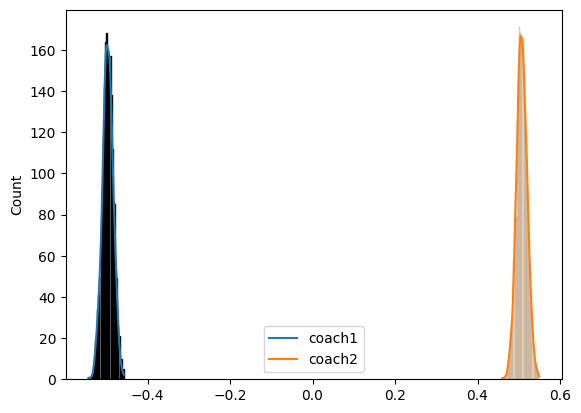

In [21]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Comparing distributions from fake data based on number of games played.

In [23]:
optimizer = Adam({"lr": 0.01})

# variables to save results
coach1_skill_inf = np.empty((3, 2000))
coach2_skill_inf = np.empty((3, 2000))

for i in range(1,4):
    pyro.clear_param_store()

    # Training loop
    num_steps = 5000
    num_games = 10**i

    guide = AutoNormal(model2)
    svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

    print(f"Training for {num_games} games")

    obs = torch.ones(num_games)
    for step in range(num_steps):    
        loss = svi.step(game_info, obs)

    predictive = Predictive(model2, guide=guide, num_samples=2000,
                            return_sites=("coach1_skill", "coach2_skill"))

    samples = predictive(game_info, obs)

    coach1_skill_inf[i-1] = samples["coach1_skill"].detach().squeeze()
    coach2_skill_inf[i-1] = samples["coach2_skill"].detach().squeeze()



Training for 10 games
Training for 100 games


KeyboardInterrupt: 

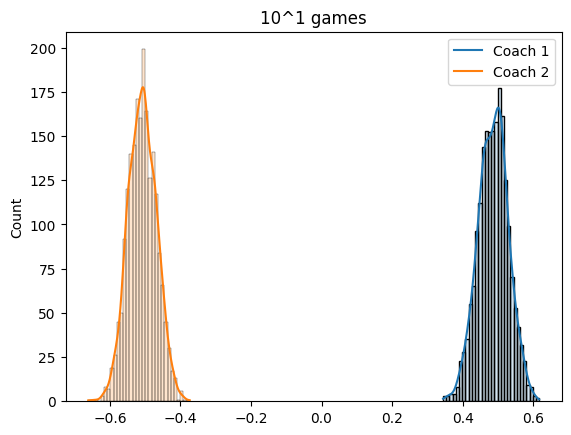

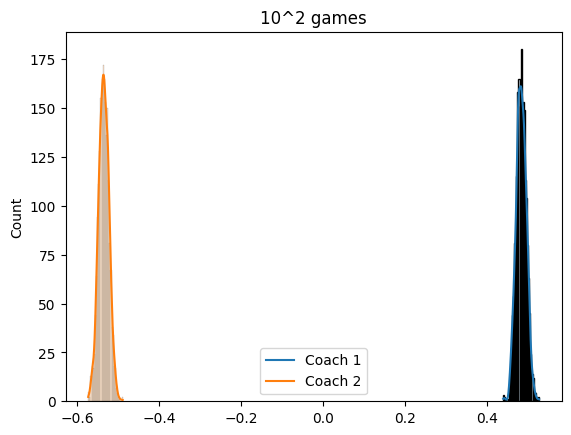

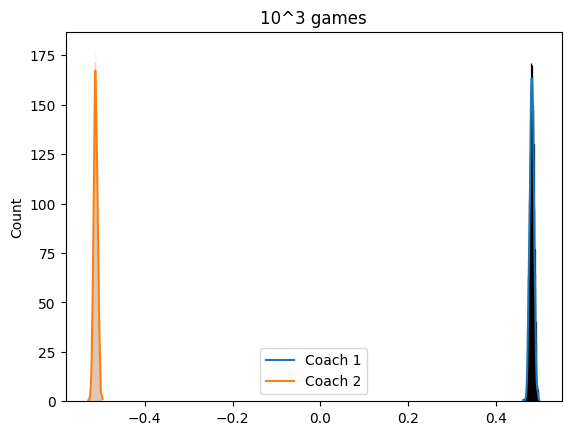

In [ ]:
#Plotting the data
sns.histplot(coach1_skill_inf[0], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[0], kde=True, alpha=0.2)
plt.title("10^1 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[1], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[1], kde=True, alpha=0.2)
plt.title("10^2 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[2], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[2], kde=True, alpha=0.2)
plt.title("10^3 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Lets try and make some fake data where coach 1 starts by losing but slowly gets better.

In [ ]:
obs1 = -torch.ones(100)
obs2 = torch.zeros(100)
obs3 = torch.ones(200)

obs = torch.cat((obs1, obs2, obs3))

pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000

for step in range(num_steps):    
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 9522.317188560963


Step 100 : loss = 2914.79979211092
Step 200 : loss = 2886.565900504589
Step 300 : loss = 2826.241234779358
Step 400 : loss = 2769.8708007335663
Step 500 : loss = 2785.479966700077
Step 600 : loss = 2807.864278614521
Step 700 : loss = 2784.997269690037
Step 800 : loss = 2786.235098183155
Step 900 : loss = 2792.943576872349
Step 1000 : loss = 2779.9934463500977
Step 1100 : loss = 2781.629343509674
Step 1200 : loss = 2781.915160179138
Step 1300 : loss = 2751.3054000735283
Step 1400 : loss = 2762.0445615053177
Step 1500 : loss = 2763.8644583821297
Step 1600 : loss = 2785.6296651363373
Step 1700 : loss = 2762.4673290252686
Step 1800 : loss = 2762.5354180336
Step 1900 : loss = 2769.5310938954353
Step 2000 : loss = 2799.4221680164337
Step 2100 : loss = 2787.998417377472
Step 2200 : loss = 2787.537132680416
Step 2300 : loss = 2786.571065545082
Step 2400 : loss = 2787.744773507118
Step 2500 : loss = 2773.196148991585
Step 2600 : loss = 2798.641106069088
Step 2700 : loss = 2776.321596264839
Step

In [ ]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

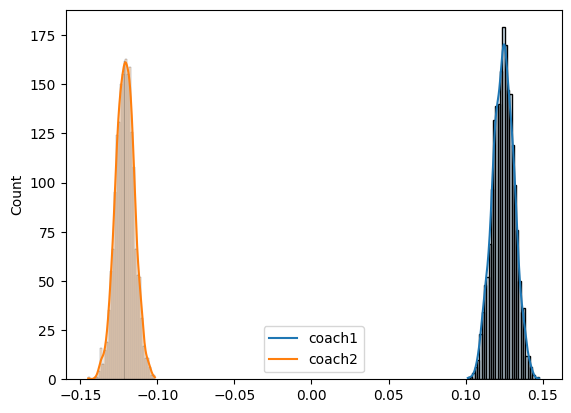

In [ ]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()